In [ ]:
#GRUPO:
#Giovanna Arana Paganotti - 11315033
#Glaucia Pamponet Sobrinho - 11271000
#Thais Bonjorni Nobre de Jesus - 10719302


# **Imports e Métodos**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.special import expit
from google.colab import drive
from google_drive_downloader import GoogleDriveDownloader as gdd
from google.colab import drive
drive.mount("/content/drive")
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import plotly.figure_factory as ff
import seaborn as sn

google_id = '1KCUFOlIiEnYWYmMQqimb2vgT0iL8O1H0' #datasets - id no google drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def probsLogicos(problema):
  gdd.download_file_from_google_drive(file_id=google_id, dest_path = './problem'+problema+'.csv', showsize = True) #download no drive
  data = pd.read_csv("/content/drive/Shareddrives/Voodoo Chicken/5SEM/IA/MLP/CSVs/problem"+problema+".csv", header=None).to_numpy() #faz array para facilitar o uso
  # print('Dataset '+problema+":")
  # print(data, "\n\n")
  
  #recorte de entradas e saidas
  Xtrain = data[0:, 0:2].T
  Ytrain = data[0:, 2:3].T

  #cria o modelo
  modelo = MultPerc(2, 31, 1)	#entrada, escondida, saida

  print("PESOS ESCONDIDA\n",modelo.Pesc.T)
  print("\nPESOS SAIDA\n",modelo.Psaida)
  print("\nBIAS ESCONDIDA\n",modelo.Besc.T)
  print("\nBIAS SAIDA\n",modelo.Bsaida.T)
  print("\n\n")

  # print(problema+" Antes do Treino:")
  # print(feedforward(modelo, Xtrain), "\n")

  back(modelo, Xtrain, Ytrain, 0.1, 0.001)	#modelo, entradasDataset, saidasDataset, taxa aprend, limiteErro

  # print("\n"+problema+" Depois do Treino:")
  # print(feedforward(modelo, Xtrain))

  return modelo

In [ ]:
def fazBin(resultado):
  resultado2 = np.copy(resultado)
  rescop = resultado2.astype(int)
  for i in range(0, resultado2.shape[0]):
    r = 0
    for m in range(0, int(len(resultado2[i]))):
      if resultado2[i, m] > r:
        r = resultado2[i, m]
    ja = False
    for o in range(0, int(len(resultado2[i]))):
      if resultado2[i, o] == r and not ja:
        ja = True
        rescop[i, o] = int(1)
      else: rescop[i, o] = int(0)
    
  return rescop

In [ ]:
def fazLetra(res):
  resL = []
  for h in res: resL.append("O")
  resL = np.array(resL)
  for i in range(0, res.shape[0]):
    if np.array_equal(res[i], np.array([1,0,0,0,0,0,0])): resL[i] = "A"
    elif np.array_equal(res[i], np.array([0,1,0,0,0,0,0])): resL[i] = "B"
    elif np.array_equal(res[i], np.array([0,0,1,0,0,0,0])): resL[i] = "C"
    elif np.array_equal(res[i], np.array([0,0,0,1,0,0,0])): resL[i] = "D"
    elif np.array_equal(res[i], np.array([0,0,0,0,1,0,0])): resL[i] = "E"
    elif np.array_equal(res[i], np.array([0,0,0,0,0,1,0])): resL[i] = "J"
    else: resL[i] = "K"
  
  return resL

# **Estrutura do Modelo**

In [ ]:
class MultPerc():
  def __init__(self, entra, esc, said):
    self.entrada = entra
    self.escondida = esc
    self.saida = said
    self.Pesc, self.Besc = self.geraPesos(esc, entra)
    self.Psaida, self.Bsaida = self.geraPesos(said, esc)

  def geraPesos(self, lin, col):
    P = np.random.ranf((lin, col)) - 0.5
    B = np.ones((lin, 1))
    return P, B

  def guardResult(self, resesc, resFesc, resai, resFsai):
    self.resesc = resesc
    self.resFesc = resFesc
    self.resai = resai
    self.resFsai = resFsai
    
  def guardEpoca(self, epc, lista):
    self.epocas = epc
    self.listaErro = lista


# **Função de Ativação e Derivada**

In [ ]:
def funcAtivacao (av):
  norberto = expit(av) #1/(1+exp(-x))
  return norberto
  
def derivada (av):
    return av - np.power(av, 2) #(funcAtivacao(av) * (1 - funcAtivacao(av)))

# **FeedForward**

In [ ]:
def feedforward(modelo, linha):
  #passando pela escondida
  modelo.resesc = np.dot(modelo.Pesc, linha) + modelo.Besc
  modelo.resFesc = funcAtivacao(modelo.resesc) #RESULTADO DA ESCONDIDA 

  #passando pela saida
  modelo.resai = np.dot(modelo.Psaida, modelo.resFesc) + modelo.Bsaida
  res = funcAtivacao(modelo.resai) #RESULTADO DA SAIDA USANDO A ESCONDIDA
  modelo.resFsai = res

  return res

# **Retro-Propagação de Erro - BackPropagation**

In [ ]:
def back(modelo, X, Y, learningRate, tresh):
  errorList = []
  tamData = int(len(X.T))
  erroCorr = 2*tresh
  epocas = 0

  #rodando epocas até o erro ser aceitavel
  while(erroCorr > tresh):
    #passa por cada linha do dataset enviado no parametro
    for i in range(0, tamData):
      caso = X[0:len(X), i:i+1]
      resposta = Y[0:len(Y), i:i+1]
      
      res = feedforward(modelo, caso)

      erroCorr += float(np.sum((np.sum((res - resposta)**2, axis = 0, keepdims = True)), axis = 1, keepdims = True))

      #TREINAMENTO DAS CAMADAS
      dsaida = -2*(res - resposta)*(derivada(res)) #VARIAÇÂO SAIDA
      dPsaida = np.dot(dsaida, modelo.resFesc.T)
      dBsaida = np.sum(dsaida, axis = 1, keepdims = True)

      desc = np.dot(modelo.Psaida.T, dsaida)*(derivada(modelo.resFesc)) #VARIAÇÃO ESCONDIDA
      dPesc = np.dot(desc, caso.T) 
      dBesc = np.sum(desc, axis = 1, keepdims = True)

      #ATUALIZAÇÃO NO MODELO
      modelo.Psaida += learningRate*dPsaida
      modelo.Bsaida += learningRate*dBsaida
      modelo.Pesc += learningRate*dPesc
      modelo.Besc += learningRate*dBesc

    erroCorr = erroCorr/tamData
    errorList.append(erroCorr) #lista com erros das epocas
    epocas += 1

    #print("ERRO:", erroCorr)

  modelo.guardEpoca(epocas, errorList)
  
  fig = plt.figure(figsize = (8,7))
  fig.patch.set_facecolor('white')
  plt.plot(range(0, modelo.epocas), modelo.listaErro, "r-")
  plt.grid(False)
  plt.title("Erro Por Epocas")
  plt.show()



# **Teste dos Problemas Lógicos**

### **AND**

PESOS ESCONDIDA
 [[-0.46853362  0.28577599  0.36189913 -0.03294468  0.45496597 -0.26429986
  -0.06876314  0.48939877  0.07330527 -0.25945897  0.28997147  0.00228164
   0.1011787   0.33671854 -0.45702242 -0.42687395  0.08986996 -0.19929772
   0.09809395  0.21019826  0.13063183 -0.33959392 -0.10439733  0.49979621
   0.45975056 -0.40047714 -0.28151527 -0.46213332 -0.08127592  0.45396649
  -0.48907596]
 [-0.4393178  -0.21702415  0.04937601  0.05028179 -0.09870783  0.43360636
  -0.14321945  0.42206054  0.38915452 -0.18574781  0.01841321 -0.47764089
   0.44048054 -0.04875634  0.0911756   0.33801614  0.18496998  0.47867275
  -0.43186539 -0.41828756 -0.1652345   0.25044101  0.05525011 -0.47530238
  -0.02306588  0.42200078 -0.22260885  0.17644044 -0.30367302  0.09565156
   0.00390239]]

PESOS SAIDA
 [[ 0.4539835   0.42311397  0.41863053 -0.43478592 -0.361823   -0.23876528
   0.28796231 -0.17831412  0.14710006  0.37657815 -0.39000888 -0.2884338
  -0.0482693   0.36085747 -0.15741784  0.12866278  

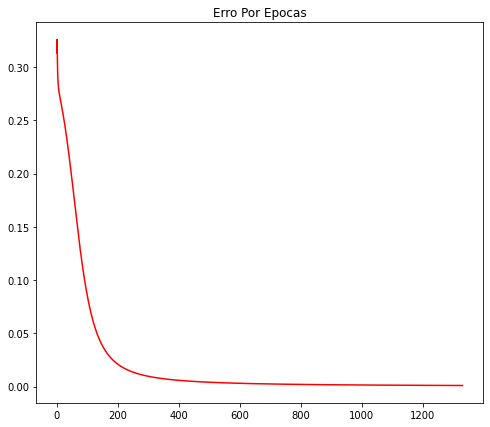

In [ ]:
modelAND = probsLogicos("AND")

### **OR**

PESOS ESCONDIDA
 [[-0.44530853  0.42181291  0.00094731  0.4658991  -0.3182182  -0.00679266
   0.34557967 -0.43945928  0.22997311  0.4192854   0.24995261 -0.3954971
   0.19868187  0.17724077 -0.28933005  0.07518616 -0.13131004 -0.13413765
  -0.25615023 -0.31033716 -0.26869909 -0.44226794  0.21329866  0.48434963
   0.47658595 -0.03626733 -0.00719977 -0.4636237  -0.42985735  0.0051435
   0.31328441]
 [-0.41372421  0.25685309  0.32831032 -0.00291991  0.20569499 -0.43634794
   0.06946241 -0.34206198  0.40767077  0.17527343  0.37647872  0.30903626
   0.16227705  0.04732308 -0.2850923   0.21151392  0.30515531  0.31075017
  -0.30646067 -0.46811392  0.16062207 -0.00647246  0.44297143  0.02886156
   0.27023241  0.37980195  0.3438015   0.10483634  0.2720032   0.24239059
   0.11645407]]

PESOS SAIDA
 [[ 0.25086131 -0.47232973  0.31670321 -0.2968927   0.459779    0.07928984
   0.47254112 -0.43940924  0.31792837  0.2432063  -0.40360243  0.34285386
  -0.48698175  0.3545783   0.06104146  0.05554996  0

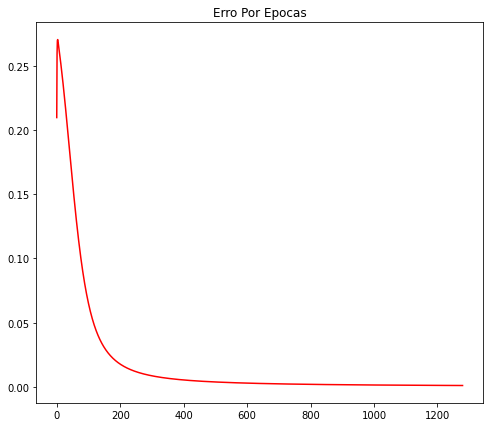

In [ ]:
modelOR = probsLogicos("OR")

### **XOR**

PESOS ESCONDIDA
 [[ 0.44659687  0.32979592  0.12927493  0.04695103 -0.01990185 -0.01672903
   0.18616065  0.47998084  0.26512689 -0.30929311 -0.28212365 -0.3705241
   0.376933   -0.3480356   0.15376881 -0.44454021 -0.02945822  0.05677673
  -0.15484301 -0.13923225 -0.14779142  0.18094482 -0.48325474  0.36524054
   0.35366197 -0.15926957 -0.32129217 -0.47527732  0.45205761  0.26285471
   0.10454001]
 [ 0.41286515 -0.43096843  0.48861088 -0.07534326 -0.03275146  0.46209048
   0.37233302 -0.02808761 -0.08930045  0.18270325 -0.06363757  0.25234385
  -0.30728904  0.40032467  0.30329704  0.34601707 -0.16812311 -0.49665841
  -0.18753454  0.20052611 -0.23924981  0.31287916  0.19563051 -0.06617524
   0.46149757 -0.11894198 -0.1104551   0.00833205 -0.47683613  0.3781762
  -0.02099325]]

PESOS SAIDA
 [[-0.19409671  0.32999519 -0.25521695  0.40265003  0.11314878 -0.03046429
   0.19310291 -0.14785542  0.22812959  0.32037209 -0.38154596 -0.12219952
   0.48333843 -0.0182324   0.47291507 -0.28747977  0

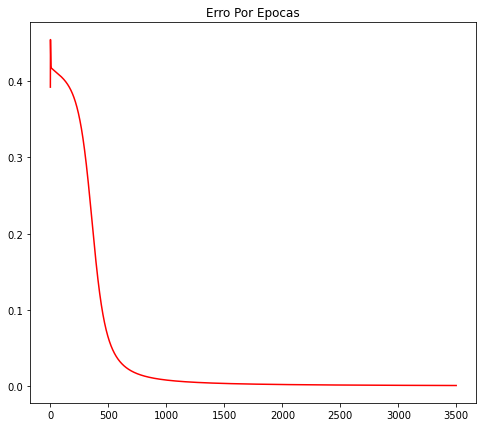

In [ ]:
modelXOR = probsLogicos("XOR")

# **Dataset Caracteres Limpos**

### **Treinamento**

Resultados do Conjunto:

    0  1  2  3  4  5  6
0   0  1  0  0  0  0  0
1   1  0  0  0  0  0  0
2   0  0  1  0  0  0  0
3   0  0  0  1  0  0  0
4   0  0  0  0  0  1  0
5   0  0  0  1  0  0  0
6   1  0  0  0  0  0  0
7   0  0  0  0  0  0  1
8   0  0  0  0  1  0  0
9   0  1  0  0  0  0  0
10  0  0  0  0  0  0  1
11  0  0  0  1  0  0  0
12  0  0  0  0  1  0  0
13  0  0  1  0  0  0  0 




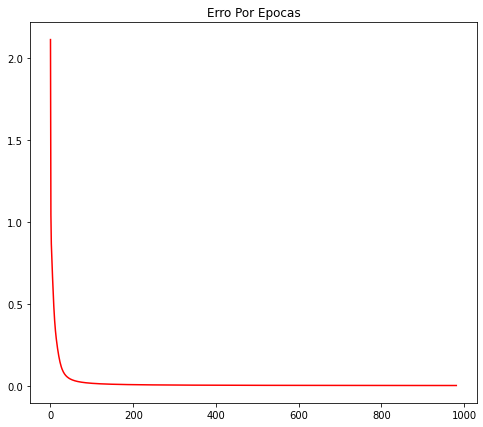


 Depois do Treino:



,0,1,2,3,4,5,6
0,0.001459,0.977508,0.009891,0.012318,0.017394,0.011038,0.001652
1,0.980521,0.002447,0.006720,0.003660,0.007632,0.013831,0.005008
2,0.007076,0.005959,0.982439,0.011836,0.006323,0.012742,0.006654
3,0.005221,0.008822,0.005161,0.986338,0.003399,0.009901,0.008696
4,0.015663,0.014321,0.014324,0.010694,0.000084,0.969333,0.014748
5,0.007582,0.010232,0.008903,0.982970,0.007176,0.005654,0.003056
6,0.980241,0.002947,0.004196,0.004891,0.014836,0.008049,0.009479
7,0.006079,0.001549,0.011273,0.010160,0.013797,0.010615,0.981076
8,0.013622,0.009634,0.008464,0.003863,0.978177,0.000235,0.015730
9,0.001882,0.980658,0.003686,0.010104,0.012797,0.005456,0.005841


In [ ]:
gdd.download_file_from_google_drive(file_id=google_id, dest_path = './caracteres-limpo.csv', showsize = True)
dataLIMPO = pd.read_csv("/content/drive/Shareddrives/Voodoo Chicken/5SEM/IA/MLP/CSVs/caracteres-limpo.csv", header=None, low_memory=False)
dataLIMPO.head(dataLIMPO.shape[0])


#print(dataLIMPO, "\n\n")
dataLIMPO = dataLIMPO.to_numpy()

#SEPARAÇÃO DAS ENTRADAS E SAIDAS
Xtrain = dataLIMPO[0:, 0:63]
Ytrain = dataLIMPO[0:, 63:]

entreino, enteste, saitreino, saiteste = train_test_split(Xtrain, Ytrain, test_size=0.3)

particaoENT = pd.DataFrame(entreino)
particaoSAI = pd.DataFrame(saitreino)
particaoENT.to_csv('/content/drive/Shareddrives/Voodoo Chicken/5SEM/IA/MLP/CSVs/arquivoEnt.csv')
particaoSAI.to_csv('/content/drive/Shareddrives/Voodoo Chicken/5SEM/IA/MLP/CSVs/arquivoSai.csv')

# #cria o modelo
modelo = MultPerc(63, 31, 7)	#entrada, escondida, saida

# print(" Antes do Treino:\n")
# antesLIMPO = pd.DataFrame(forwardProp(modelo, entreino.T).T)
# print(antesLIMPO.head(antesLIMPO.shape[0]), "\n\n")

print("Resultados do Conjunto:\n")
saidaset = pd.DataFrame(saitreino)
print(saidaset.head(saidaset.shape[0]), "\n\n")

back(modelo, entreino.T, saitreino.T, 0.1, 0.001)	#modelo, entradasDataset, saidasDataset, taxa, limiteErro

print("\n Depois do Treino:\n")
limpoTREINO = pd.DataFrame(feedforward(modelo, entreino.T).T)
limpoTREINO.head(limpoTREINO.shape[0])

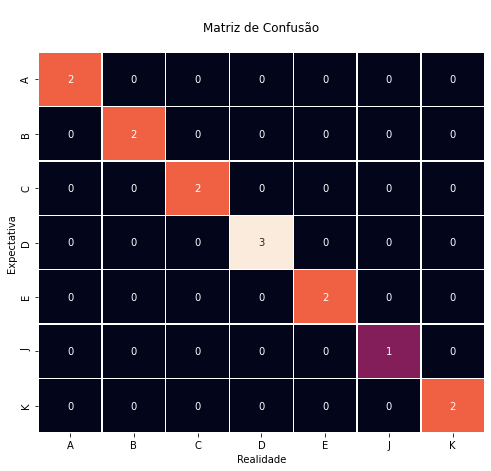

In [ ]:
jedo = fazLetra(fazBin(feedforward(modelo, entreino.T).T))
jeda = fazLetra(saitreino)
cm = confusion_matrix(jedo, jeda, binary=False)
uniao = np.union1d(jeda, jedo)
df_cm = pd.DataFrame(cm,  columns=np.unique(uniao), index = np.unique(uniao))
df_cm.index.name = 'Expectativa'
df_cm.columns.name = 'Realidade'
figu = plt.figure(figsize = (8,7))
figu.patch.set_facecolor('white')
plt.title("\nMatriz de Confusão\n")
sn.heatmap(df_cm, annot=True, linewidths=.5, cbar = False) 

### **Teste**

Resposta do Conjunto de Teste

In [ ]:

#TESTE LIMPO
jedo = fazLetra(saiteste) #transforma resposta certa em letra
print("Resultado certo:", jedo)
testeset = pd.DataFrame(saiteste)
print(testeset.head(saiteste.shape[0]), "\n\n")

print("Resultado Obtido:")
limpoTESTE = pd.DataFrame(feedforward(modelo, enteste.T).T)
print(limpoTESTE.head(limpoTESTE.shape[0]), "\n\n")

variavel = fazBin(limpoTESTE) #transforma resposta da rede em binario
jeda = fazLetra(variavel) #transforma binario em letra
print("Resultado Aproximado:", jeda)
print(pd.DataFrame(variavel).head(limpoTESTE.shape[0]))




Resultado certo: ['J' 'J' 'E' 'K' 'C' 'B' 'A']
   0  1  2  3  4  5  6
0  0  0  0  0  0  1  0
1  0  0  0  0  0  1  0
2  0  0  0  0  1  0  0
3  0  0  0  0  0  0  1
4  0  0  1  0  0  0  0
5  0  1  0  0  0  0  0
6  1  0  0  0  0  0  0 


Resultado Obtido:
          0         1         2         3         4         5         6
0  0.017362  0.006955  0.027058  0.017054  0.000337  0.936406  0.013302
1  0.021512  0.005654  0.028856  0.009769  0.000454  0.913060  0.008828
2  0.007625  0.011281  0.020218  0.003356  0.629172  0.000636  0.107243
3  0.062037  0.006897  0.015454  0.225202  0.030894  0.011342  0.053890
4  0.010209  0.005112  0.963112  0.039529  0.004849  0.021398  0.005390
5  0.002630  0.075784  0.003841  0.510227  0.025436  0.002083  0.015081
6  0.415659  0.006425  0.009961  0.005448  0.051861  0.004422  0.004474 


Resultado Aproximado: ['J' 'J' 'E' 'D' 'C' 'D' 'A']
   0  1  2  3  4  5  6
0  0  0  0  0  0  1  0
1  0  0  0  0  0  1  0
2  0  0  0  0  1  0  0
3  0  0  0  1  0  0  0
4 

In [ ]:
print(modelo.Pesc)
print(modelo.Besc)

[[ 0.26047799  0.07391095 -0.36587968 ... -0.25879364 -0.4552476
   0.01699951]
 [ 0.3191164   0.18422942  0.40365925 ... -0.21009339 -0.13463881
  -0.00853882]
 [-0.31184053 -0.25556025  0.22945751 ... -0.24927963  0.12510901
   0.44565529]
 ...
 [-0.08856949 -0.51032369  0.4402695  ...  0.12334668  0.30117726
  -0.6457071 ]
 [ 0.13903463  0.00287298 -0.21377994 ... -0.34172216  0.15066149
   0.44275646]
 [ 0.34623891 -0.07462173  0.15622983 ... -0.57143244  0.0912328
   0.69799131]]
[[0.93260443]
 [0.93334001]
 [0.9411694 ]
 [0.99099403]
 [0.98627904]
 [1.03675006]
 [1.04813623]
 [1.07691792]
 [1.00542261]
 [1.04875283]
 [1.03647637]
 [1.09286167]
 [1.00426366]
 [0.96906682]
 [0.9596681 ]
 [0.95957328]
 [0.95933848]
 [1.01241881]
 [0.94630649]
 [1.02108079]
 [1.00657324]
 [1.00677672]
 [0.96486978]
 [1.01093359]
 [1.04421914]
 [0.92772853]
 [0.85751634]
 [0.93763385]
 [1.00708835]
 [1.02146922]
 [0.96639764]]


### **Matriz de Confusão**

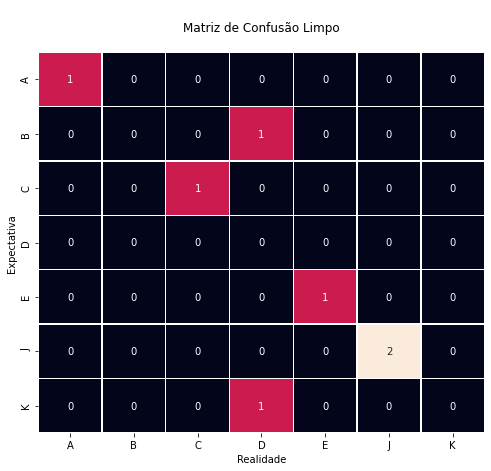

In [ ]:
#MATRIZ
cm = confusion_matrix(jedo, jeda, binary=False)

#UNIAO DOS LABELS PARA REPRESENTAR
uniao = np.union1d(jeda, jedo)

#REP GRAFICA
df_cm = pd.DataFrame(cm,  columns=np.unique(uniao), index = np.unique(uniao))
df_cm.index.name = 'Expectativa'
df_cm.columns.name = 'Realidade'
figu = plt.figure(figsize = (8,7))
figu.patch.set_facecolor('white')
plt.title("\nMatriz de Confusão Limpo\n")
sn.heatmap(df_cm, annot=True, linewidths=.5, cbar = False) 

# **Dataset Caracteres com Ruído**

### **Treinamento**

Resultados do Conjunto:

    0  1  2  3  4  5  6
0   0  1  0  0  0  0  0
1   0  0  1  0  0  0  0
2   0  0  0  0  0  1  0
3   1  0  0  0  0  0  0
4   0  0  0  0  1  0  0
5   0  0  0  1  0  0  0
6   0  1  0  0  0  0  0
7   0  0  0  0  0  0  1
8   0  0  0  0  0  1  0
9   0  1  0  0  0  0  0
10  0  0  0  0  1  0  0
11  0  0  0  0  0  0  1
12  0  0  0  1  0  0  0
13  1  0  0  0  0  0  0 




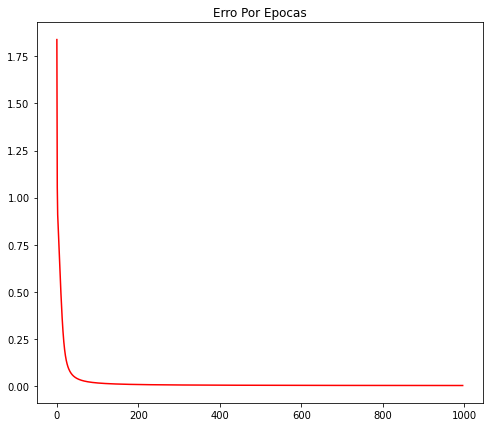


 Depois do Treino:



,0,1,2,3,4,5,6
0,0.009013,0.981638,0.004312,0.008676,0.013724,0.002006,0.002570
1,0.013463,0.014858,0.972766,0.014017,0.003380,0.013042,0.011979
2,0.014029,0.004032,0.007944,0.008111,0.010963,0.979035,0.008364
3,0.976908,0.006033,0.011810,0.001655,0.009269,0.008350,0.004159
4,0.005919,0.005452,0.003029,0.012165,0.979064,0.005292,0.009345
5,0.012518,0.011079,0.003124,0.978669,0.003990,0.009378,0.010984
6,0.007632,0.986058,0.007954,0.010766,0.008500,0.004512,0.006194
7,0.012081,0.007837,0.012442,0.006675,0.005763,0.006142,0.980288
8,0.012439,0.005164,0.009296,0.007389,0.009691,0.979345,0.007630
9,0.003285,0.983609,0.011031,0.012406,0.013027,0.001736,0.007736


In [ ]:
gdd.download_file_from_google_drive(file_id=google_id, dest_path = './caracteres-ruido.csv', showsize = True)
dataRUIDO = pd.read_csv("/content/drive/Shareddrives/Voodoo Chicken/5SEM/IA/MLP/CSVs/caracteres-ruido.csv", header=None, low_memory=False)
dataRUIDO.head(dataRUIDO.shape[0])


#print(dataLIMPO, "\n\n")
dataRUIDO = dataRUIDO.to_numpy()

#SEPARA ENTRADA DA SAIDA
XtrainR = dataRUIDO[0:, 0:63]
YtrainR = dataRUIDO[0:, 63:]

#DIVISAO ALEATORIA DO DATASET EM PARTE DE TREINO E TESTE
entreinoR, entesteR, saitreinoR, saitesteR = train_test_split(XtrainR, YtrainR, test_size=0.3)

particaoENTr = pd.DataFrame(entreino)
particaoSAIr = pd.DataFrame(saitreino)
particaoENTr.to_csv('/content/drive/Shareddrives/Voodoo Chicken/5SEM/IA/MLP/CSVs/arquivoEntR.csv')
particaoSAIr.to_csv('/content/drive/Shareddrives/Voodoo Chicken/5SEM/IA/MLP/CSVs/arquivoSaiR.csv')

# #cria o modelo
modeloRuido = MultPerc(63, 31, 7)	#entrada, escondida, saida

# print(" Antes do Treino:\n")
# antesLIMPO = pd.DataFrame(forwardProp(modelo, entreino.T).T)
# print(antesLIMPO.head(antesLIMPO.shape[0]), "\n\n")

print("Resultados do Conjunto:\n")
saidasetR = pd.DataFrame(saitreinoR)
print(saidasetR.head(saidasetR.shape[0]), "\n\n")

back(modeloRuido, entreinoR.T, saitreinoR.T, 0.1, 0.001)	#modelo, entradasDataset, saidasDataset, taxa, limiteErro

print("\n Depois do Treino:\n")
ruidoTREINO = pd.DataFrame(feedforward(modeloRuido, entreinoR.T).T)
ruidoTREINO.head(ruidoTREINO.shape[0])

In [ ]:
print(modeloRuido.epocas)

997


Matriz de Confusao do Treinamento

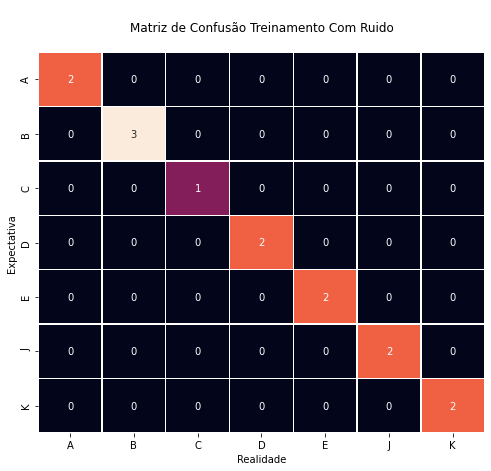

In [ ]:
#UNIAO DAS RESPOSTAS PARA FAZER TODOS OS LABELS POSSIVEIS DA MATRIZ
jedo = fazLetra(fazBin(feedforward(modeloRuido, entreinoR.T).T))
jeda = fazLetra(saitreinoR)

#MONTA MATRIZ
cm = confusion_matrix(jedo, jeda, binary=False)
uniao = np.union1d(jeda, jedo)
df_cm = pd.DataFrame(cm,  columns=np.unique(uniao), index = np.unique(uniao))
df_cm.index.name = 'Expectativa'
df_cm.columns.name = 'Realidade'
figu = plt.figure(figsize = (8,7))
figu.patch.set_facecolor('white')
plt.title("\nMatriz de Confusão Treinamento Com Ruido\n")
sn.heatmap(df_cm, annot=True, linewidths=.5, cbar = False) 

### **Teste**

In [ ]:

#TESTE RUIDO
jedoR = fazLetra(saitesteR) #transforma resposta certa em letra
print("Resultado certo:", jedoR) 
testesetR = pd.DataFrame(saitesteR)
print(testesetR.head(saitesteR.shape[0]), "\n\n")

print("Resultado Obtido:")
ruidoTESTE = pd.DataFrame(feedforward(modeloRuido, entesteR.T).T)
print(ruidoTESTE.head(ruidoTESTE.shape[0]), "\n\n")

variavelR = fazBin(ruidoTESTE) #transforma resposta da rede em binario
jedaR = fazLetra(variavelR) #transforma binario em letra
print("Resultado Aproximado:", jedaR)
print(pd.DataFrame(variavelR).head(ruidoTESTE.shape[0]))


Resultado certo: ['J' 'D' 'C' 'C' 'A' 'E' 'K']
   0  1  2  3  4  5  6
0  0  0  0  0  0  1  0
1  0  0  0  1  0  0  0
2  0  0  1  0  0  0  0
3  0  0  1  0  0  0  0
4  1  0  0  0  0  0  0
5  0  0  0  0  1  0  0
6  0  0  0  0  0  0  1 


Resultado Obtido:
          0         1         2         3         4         5         6
0  0.004156  0.003575  0.016767  0.004866  0.012889  0.934905  0.016691
1  0.006509  0.151919  0.002438  0.707310  0.007446  0.011866  0.008411
2  0.001933  0.130445  0.141001  0.002067  0.051686  0.098772  0.208846
3  0.003489  0.025549  0.347556  0.070387  0.004412  0.062535  0.020313
4  0.848550  0.011453  0.003727  0.006809  0.005864  0.120563  0.050227
5  0.008746  0.078105  0.005864  0.064394  0.071950  0.058034  0.034936
6  0.007634  0.000874  0.001268  0.030480  0.170931  0.010596  0.551233 


Resultado Aproximado: ['J' 'D' 'K' 'C' 'A' 'B' 'K']
   0  1  2  3  4  5  6
0  0  0  0  0  0  1  0
1  0  0  0  1  0  0  0
2  0  0  0  0  0  0  1
3  0  0  1  0  0  0  0
4 

### **Matriz de Confusão**

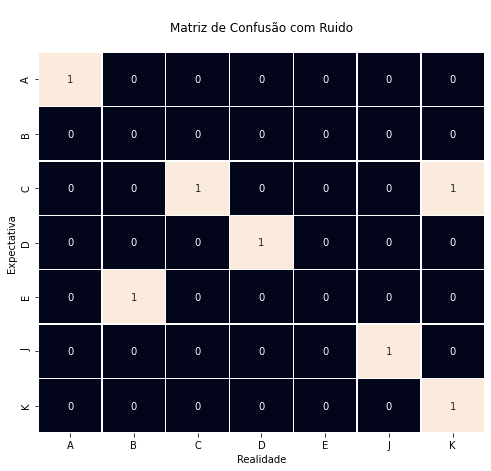

In [ ]:
#MATRIZ
cm = confusion_matrix(jedoR, jedaR, binary=False)

#UNIAO DOS LABELS POSSIVEIS NA MATRIZ
uniao = np.union1d(jedaR, jedoR)

#REP GRAFICA
df_cm = pd.DataFrame(cm,  columns=np.unique(uniao), index = np.unique(uniao))
df_cm.index.name = 'Expectativa'
df_cm.columns.name = 'Realidade'
figu = plt.figure(figsize = (8,7))
figu.patch.set_facecolor('white')
plt.title("\nMatriz de Confusão com Ruido\n")
sn.heatmap(df_cm, annot=True, linewidths=.5, cbar = False) 